# **# Solar Radiation Prediction**

About Dataset

Context

Space Apps Moscow was held on April 29th & 30th. Thank you to the 175 people who joined the International Space Apps Challenge at this location!


Content

The dataset contains such columns as: "wind direction", "wind speed", "humidity" and temperature. The response parameter that is to be predicted is: "Solar_radiation". It contains measurements for the past 4 months and you have to predict the level of solar radiation.
Just imagine that you've got solar energy batteries and you want to know will it be reasonable to use them in future?


https://www.kaggle.com/datasets/dronio/SolarEnergy

# Import the Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, feature_selection, svm, metrics,preprocessing
from tqdm import tqdm
import tensorflow as tf
import re

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dronio/SolarEnergy

100% 511k/511k [00:00<00:00, 941kB/s]
100% 511k/511k [00:00<00:00, 940kB/s]


In [ ]:
!unzip /content/SolarEnergy.zip

Archive:  /content/SolarEnergy.zip
  inflating: SolarPrediction.csv     


# **read dataset from CSV using Pandas**

In [ ]:
dataset=pd.read_csv("SolarPrediction.csv")
dataset.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


# **desribe the dataset using Pandas**

In [ ]:
dataset.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# **check for missing values**

In [ ]:
dataset.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

# **Convert the Features to integer values**

In [ ]:
dataset['month'] = dataset['Data'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
dataset['date'] = dataset['Data'].apply(lambda x : re.search(r'(?<=\/)\d+(?=\/)', x).group(0)).astype(int)
dataset['year'] = dataset['Data'].apply(lambda x : re.search(r'(?<=\/)\d+(?=\s)', x).group(0)).astype(int)

dataset['hour'] = dataset['Time'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
dataset['minute'] = dataset['Time'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)
dataset['second'] = dataset['Time'].apply(lambda x : re.search(r'\d+$', x).group(0)).astype(int)

dataset['risehour'] = dataset['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
dataset['riseminuter'] = dataset['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)
dataset['sethour'] = dataset['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
dataset['setminute'] = dataset['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [ ]:
dataset.drop(['UNIXTime','Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,month,date,year,hour,minute,second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,6,13,18,13


In [ ]:
dataset['year'].unique(), dataset['risehour'].unique()


(array([2016]), array([6]))

In [ ]:
dataset.drop(['year', 'risehour'], axis = 1, inplace = True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Radiation               32686 non-null  float64
 1   Temperature             32686 non-null  int64  
 2   Pressure                32686 non-null  float64
 3   Humidity                32686 non-null  int64  
 4   WindDirection(Degrees)  32686 non-null  float64
 5   Speed                   32686 non-null  float64
 6   month                   32686 non-null  int64  
 7   date                    32686 non-null  int64  
 8   hour                    32686 non-null  int64  
 9   minute                  32686 non-null  int64  
 10  second                  32686 non-null  int64  
 11  riseminuter             32686 non-null  int64  
 12  sethour                 32686 non-null  int64  
 13  setminute               32686 non-null  int64  
dtypes: float64(4), int64(10)
memory usage:

In [ ]:
dataset.drop(['second'], axis = 1, inplace = True)

# **the Final Dataset after Updating**

In [ ]:
dataset

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,month,date,hour,minute,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,44,30.43,102,145.42,6.75,12,1,0,20,41,17,42
32682,1.17,44,30.42,102,117.78,6.75,12,1,0,15,41,17,42
32683,1.20,44,30.42,102,145.19,9.00,12,1,0,10,41,17,42
32684,1.23,44,30.42,101,164.19,7.87,12,1,0,5,41,17,42


# **Preprocessing**

# hyperparameters

In [ ]:
train_fraction = 0.7
train_split = int(train_fraction * int(dataset.shape[0]))

rph = 12  # records per hour
past = 1440  # past 5 days (rph * 24 * 5)
future = 288  # next 1 day (rph * 24)
batch_size = 256  # batch size

# **Standardization**

In [ ]:
scaler= preprocessing.StandardScaler()
df = scaler.fit_transform(dataset)

# **convert the dataset to a dataframe**

In [ ]:
df=pd.DataFrame(df , columns=dataset.columns)

In [ ]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,month,date,hour,minute,riseminuter,sethour,setminute
0,-0.651811,-0.500439,0.678974,-0.616253,0.407620,-0.178738,-1.39154,1.512248,1.655482,1.589236,-0.943425,1.369126,-1.525765
1,-0.651811,-0.500439,0.678974,-0.654730,0.400285,-0.823359,-1.39154,1.512248,1.655482,1.299687,-0.943425,1.369126,-1.525765
2,-0.651748,-0.500439,0.678974,-0.693206,0.183490,-0.823359,-1.39154,1.512248,1.655482,1.010138,-0.943425,1.369126,-1.525765
3,-0.651811,-0.500439,0.678974,-0.577776,-0.069497,-0.823359,-1.39154,1.512248,1.655482,0.720589,-0.943425,1.369126,-1.525765
4,-0.651938,-0.500439,0.678974,-0.500823,-0.463407,-0.178738,-1.39154,1.512248,1.655482,0.431040,-0.943425,1.369126,-1.525765


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Radiation,32686.0,0.000000e+00,1.000015,-0.652128,-0.651748,-0.647221,0.465669,4.413056
Temperature,32686.0,5.565041e-16,1.000015,-2.758117,-0.822965,-0.177914,0.628400,3.208603
Pressure,32686.0,2.904952e-14,1.000015,-4.259540,-0.418473,0.130250,0.678974,2.508053
Humidity,32686.0,1.391260e-17,1.000015,-2.578560,-0.731683,0.384139,0.845858,1.076717
WindDirection(Degrees),32686.0,6.956302e-17,1.000015,-1.724255,-0.736625,0.050624,0.430706,2.602741
Speed,32686.0,-9.738822e-17,1.000015,-1.788859,-0.823359,-0.178738,0.465884,9.814329
month,32686.0,1.113008e-16,1.000015,-1.391540,-0.479692,0.432155,0.432155,1.344003
date,32686.0,-7.651932e-17,1.000015,-1.701824,-0.783518,0.020000,0.823518,1.741824
hour,32686.0,-8.825808e-17,1.000015,-1.672098,-0.804034,0.064031,0.932095,1.655482
minute,32686.0,-9.130146e-17,1.000015,-1.595802,-0.727155,0.141491,1.010138,1.705055


# **Train-Test Split**

In [ ]:
train_data = df.loc[0 : train_split - 1]
test_data = df.loc[train_split:]

dataset.shape, train_data.shape, test_data.shape

((32686, 13), (22880, 13), (9806, 13))

# **create x_train and y_train**

In [ ]:
x_train=train_data.values

y_train_start=past+future
y_train_end=y_train_start+train_split

y_train=df.iloc[y_train_start:y_train_end][['Radiation']].values

In [ ]:
y_train.shape , x_train.shape

((22880, 1), (22880, 13))

# **create x_test and y_test**

In [ ]:
x_test_end=(len(test_data)-future-past)
x_test = test_data.iloc[:x_test_end].values

y_start = train_split + past + future
y_test = df.iloc[y_start:][['Radiation']].values

In [ ]:
x_test.shape ,y_test.shape

((8078, 13), (8078, 1))

In [ ]:
sampling_rate = rph
sequence_length = int(past / rph)

In [ ]:
sequence_length

120

In [ ]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

# **Model Building**

In [ ]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.GRU(64, activation='relu', input_shape=(sequence_length, 13)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1),
    ]
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint.h5",
    save_best_only=True,
    monitor="val_loss",
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
)

In [ ]:
model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    #callbacks=[checkpoint_callback, early_stopping_callback],
)

Epoch 1/10
84/84 [==============================] - 36s 335ms/step - loss: 0.2441 - mean_absolute_error: 0.5357 - val_loss: 0.3113 - val_mean_absolute_error: 0.6112
Epoch 2/10
84/84 [==============================] - 27s 319ms/step - loss: 0.1731 - mean_absolute_error: 0.4251 - val_loss: 0.3111 - val_mean_absolute_error: 0.5861
Epoch 3/10
84/84 [==============================] - 23s 276ms/step - loss: 0.1792 - mean_absolute_error: 0.4128 - val_loss: 0.1944 - val_mean_absolute_error: 0.4476
Epoch 4/10
84/84 [==============================] - 26s 306ms/step - loss: 0.1568 - mean_absolute_error: 0.3773 - val_loss: 0.1741 - val_mean_absolute_error: 0.3921
Epoch 5/10
84/84 [==============================] - 26s 305ms/step - loss: 0.1340 - mean_absolute_error: 0.3384 - val_loss: 0.1438 - val_mean_absolute_error: 0.3486
Epoch 6/10
84/84 [==============================] - 31s 369ms/step - loss: 0.1251 - mean_absolute_error: 0.3227 - val_loss: 0.1423 - val_mean_absolute_error: 0.3448
Epoch 7/10

In [ ]:
print(model.history.params)

{'verbose': 1, 'epochs': 1, 'steps': 1}


In [ ]:
print(model.history.history.keys())

dict_keys([])


In [ ]:
print(model.history)

10/10 [==============================] - 1s 114ms/step


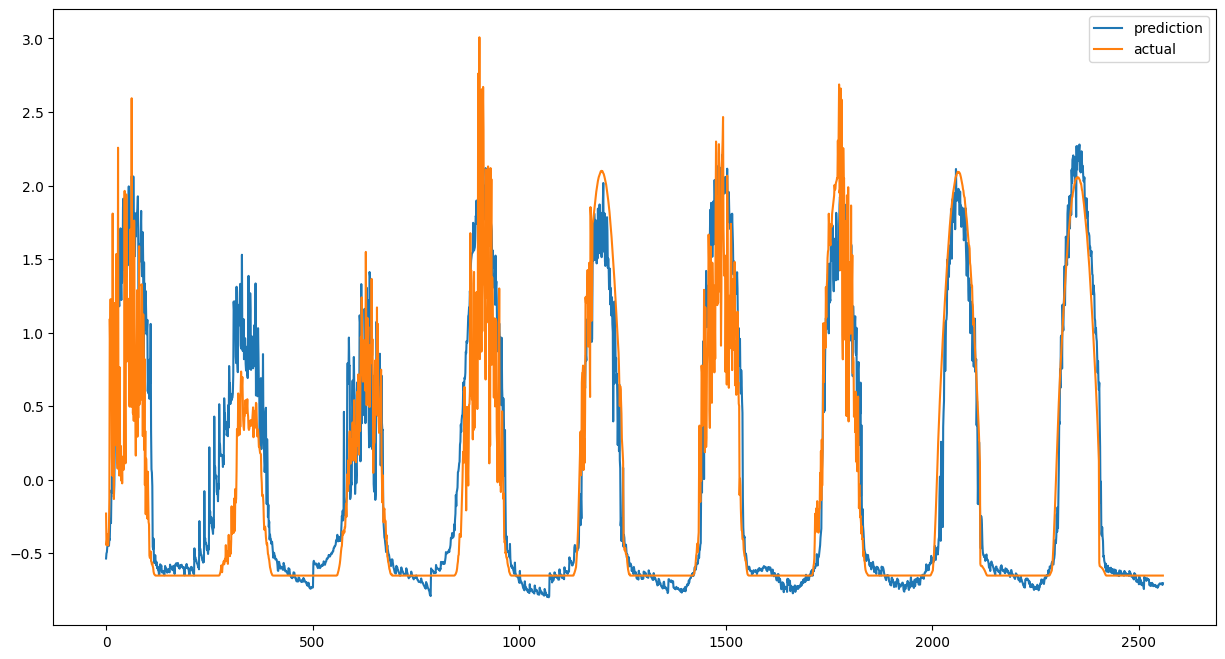

In [ ]:
test_dataset_subset = test_dataset.take(10)

predictions = model.predict(test_dataset_subset)

actual_values = []
for batch in test_dataset_subset:
    actual_values.extend(batch[1])

plt.figure(figsize=(15, 8))
plt.plot(predictions, label="prediction")
plt.plot(actual_values, label="actual")
plt.legend()
plt.show()